# **Udacity: Introduction to TensorFlow for Deep Learning**

## Lesson 6 Exercise
- Download the Flowers datasets
- Apply Transfer learning using MobileNet and Inception to clasify samples from the Flowes dataset.

## **Import Dependencies**


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

print(tf.__version__)

2.6.0


## **Get the dataset**

- Download the dataset using TensorFlow Datasets.
- split the dataset into training and validation set, with a 70:30 split.

Tensorflow dataset [documentation](https://www.tensorflow.org/datasets/catalog/overview)

\
In the resouce section, there is the dataset section which contains further catlog of different datasets. The [flower dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) was found in the image_classification set.

In [ ]:
(train_examples, validation_examples), dataset_info = tfds.load(name='tf_flowers',
                                                                split=['train[:70%]','train[70%:]'],
                                                                with_info=True,
                                                                as_supervised=True)

dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

## **Explore the dataset**

In [ ]:
# print some basic information about the dataset.

print('Tensorflow Flowers Dataset')
print('The number of class in the dataset: {}'.format(dataset_info.features['label'].num_classes))
print('Number of training samples: {}'.format(len(train_examples)))
print('Number of validation samples: {}'.format(len(validation_examples)))
print('\n Sanity check total number of samples {}'.format(len(train_examples)+ len(validation_examples)))


Tensorflow Flowers Dataset
The number of class in the dataset: 5
Number of training samples: 2569
Number of validation samples: 1101

 Sanity check total number of samples 3670


How can i get the label for the dataset? Looking at the Know Your Data website i can find the different class label for the flower dataset to be

`['daisy', 'dandelion', 'roses', 'sunflower', 'tulip']`

While this is fine we need to have the right order in the list to ensure that we are semantically correct.

I found an example showing the correct semantic label in the right order. Link [here](https://www.tensorflow.org/datasets/catalog/tf_flowers)

In [ ]:
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
# Display a sample from the dataset

for index, sample in enumerate(train_examples.take(3)):
  print('{}. Image is {} and has shape {}'.format(index, class_names[sample[-1]], sample[0].shape))

0. Image is tulips and has shape (333, 500, 3)
1. Image is sunflowers and has shape (212, 320, 3)
2. Image is sunflowers and has shape (240, 320, 3)


Worth noting that the output from the train_examples is not a batch. the iterator returns a single sample not a batched sample

## **Reformat The dataset into Batches and the correct shape**

In [ ]:
BATCH_SIZE = 42
IMG_RES = 224


def format_image(image, label):
  image = tf.image.resize(image, (IMG_RES, IMG_RES))/255.0
  return image, label


train_batches = train_examples.shuffle(len(train_examples)//4).map(format_image).batch(batch_size=BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(batch_size=BATCH_SIZE).prefetch(1)

## **Create and train a new model using MobileNetv4 as the feature extractor**

stuggling to find the documentation for the tensorflow_hub.

\
nvm. Here it is [tensorflow_hub](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)

In [ ]:
_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

MobileNet_on_Flowers_Dataset = tf.keras.Sequential([
                                hub.KerasLayer(_URL, trainable=False, input_shape=(IMG_RES, IMG_RES, 3)),
                                tf.keras.layers.Dense(units=5)
])

MobileNet_on_Flowers_Dataset.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # TODO: What is the siginificance of from_logits? it somehow affects the scale of the loss and accuracy
                                     optimizer='adam',
                                     metrics=['accuracy'])

MobileNet_on_Flowers_Dataset.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# train the model
EPOCHS=6

model_history = MobileNet_on_Flowers_Dataset.fit(train_batches,
                                                 epochs=EPOCHS,
                                                 validation_data=validation_batches)

Epoch 1/6
62/62 [==============================] - 7s 69ms/step - loss: 0.7924 - accuracy: 0.7073 - val_loss: 0.4769 - val_accuracy: 0.8465
Epoch 2/6
62/62 [==============================] - 4s 62ms/step - loss: 0.4036 - accuracy: 0.8677 - val_loss: 0.3863 - val_accuracy: 0.8701
Epoch 3/6
62/62 [==============================] - 4s 62ms/step - loss: 0.3206 - accuracy: 0.8953 - val_loss: 0.3507 - val_accuracy: 0.8774
Epoch 4/6
62/62 [==============================] - 4s 62ms/step - loss: 0.2693 - accuracy: 0.9175 - val_loss: 0.3392 - val_accuracy: 0.8856
Epoch 5/6
62/62 [==============================] - 4s 63ms/step - loss: 0.2339 - accuracy: 0.9330 - val_loss: 0.3042 - val_accuracy: 0.8955
Epoch 6/6
62/62 [==============================] - 4s 63ms/step - loss: 0.2072 - accuracy: 0.9408 - val_loss: 0.2961 - val_accuracy: 0.8955


In [ ]:
print('Model final performance')
print('Model Training: Accuracy {:.2f} and loss {:.2f}'.format(model_history.history['accuracy'][-1], model_history.history['loss'][-1]))
print('Model Validation: Accuracy {:.2f} and loss {:.2f}'.format(model_history.history['val_accuracy'][-1], model_history.history['val_loss'][-1]))

Model final performance
Model Training: Accuracy 0.94 and loss 0.21
Model Validation: Accuracy 0.90 and loss 0.30


Text(0.5, 0.98, 'Model training history')

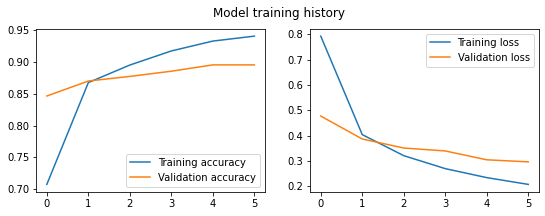

In [ ]:
# Plot model training history

epoch_range = range(EPOCHS)
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=True)

# Plot model's accuracy
axs[0].plot(epoch_range, model_history.history['accuracy'], label='Training accuracy')
axs[0].plot(epoch_range, model_history.history['val_accuracy'], label='Validation accuracy')
axs[0].legend()

axs[1].plot(epoch_range, model_history.history['loss'], label='Training loss')
axs[1].plot(epoch_range, model_history.history['val_loss'], label='Validation loss')
axs[1].legend()

fig.suptitle('Model training history')

Looking at the plot, of the model's performance during training. The biggest change was seen in the first epoch., with more gradual changes seen across the remaining epochs.

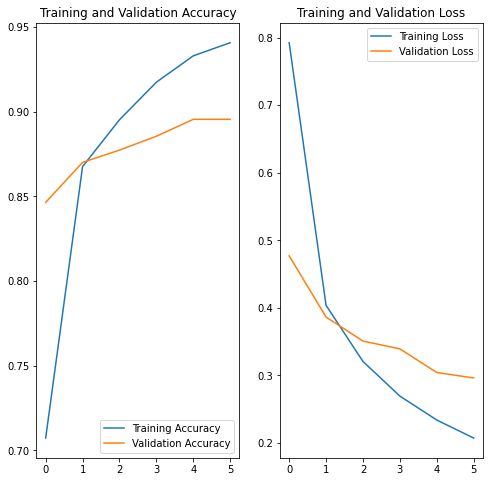

In [ ]:
# Plot Model training and validation accuracy/loss graphs
# Using lessons code

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

nah i like my plot better